# Data Science for COVID-19 (DS4C)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

# Description of the data

**1) Case Data**
* `Case.csv`: Data of COVID-19 infection cases in South Korea.

**2) Patient Data**
* `PatientInfo.csv`: Epidemiological data of COVID-19 patients in South Korea.

**3) Time Series Data**
* `Time.csv`: Time series data of COVID-19 status in South Korea,
* `TimeAge.csv`: Time series data of COVID-19 status in terms of the age in South Korea,
* `TimeGender.csv`: Time series data of COVID-19 status in terms of gender in South Korea,
* `TimeProvince.csv`: Time series data of COVID-19 status in terms of the Province in South Korea.

**4) Additional Data**
* `Region.csv`: Location and statistical data of the regions in South Korea,
* `Weather.csv`: Data of the weather in the regions of South Korea,
* `SearchTrend.csv`: Trend data of the keywords searched in NAVER which is one of the largest portals in South Korea.
* `SeoulFloating.csv`: Data of floating population in Seoul, South Korea (from SK Telecom Big Data Hub),
* `Policy.csv`: Data of the government policy for COVID-19 in South Korea.

# The Structure of the Dataset

* What color means is that they have similar properties.

* If a line is connected between columns, it means that the values of the columns are partially shared.

* The dotted lines mean weak relevance.

![Dataset structure diagram](diagram.png)

# Exploratory Data analysis

### Load the data

In [2]:
data_root = Path("./data")

case_df = pd.read_csv(data_root / "Case.csv")
patient_info_df = pd.read_csv(data_root / "PatientInfo.csv")
time_df = pd.read_csv(data_root / "Time.csv")
time_age_df = pd.read_csv(data_root / "TimeAge.csv")
time_gender_df = pd.read_csv(data_root / "TimeGender.csv")
time_province_df = pd.read_csv(data_root / "TimeProvince.csv")
region_df = pd.read_csv(data_root / "Region.csv")
weather_df = pd.read_csv(data_root / "Weather.csv")
search_df = pd.read_csv(data_root / "SearchTrend.csv")
floating_df = pd.read_csv(data_root / "SeoulFloating.csv")
policy_df = pd.read_csv(data_root / "Policy.csv")

### Case.csv

**Data of COVID-19 infection cases in South Korea**

* `case_id`: the ID of the infection case
    * case_id(7) = region_code(5) + case_number(2)
    * Check the region_code in 'Region.csv'
* `province`: Special City / Metropolitan City / Province(-do)
* `city`: City(-si) / Country (-gun) / District (-gu)
    * The value 'from other city' means that where the group infection started is other city.
* `group`: TRUE: group infection / FALSE: not group
    * If the value is 'TRUE' in this column, the value of 'infection_cases' means the name of group.
    * The values named 'contact with patient', 'overseas inflow' and 'etc' are not group infection.
* `infection_case`: the infection case (the name of group or other cases)
    * The value 'overseas inflow' means that the infection is from other country.
    * The value 'etc' includes individual cases, cases where relevance classification is ongoing after investigation, and cases under investigation.
* `confirmed`: the accumulated number of the confirmed
* `latitude`: the latitude of the group (WGS84)
* `longitude`: the longitude of the group (WGS84)

In [3]:
case_df.head()

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Yongsan-gu,True,Itaewon Clubs,139,37.538621,126.992652
1,1000002,Seoul,Gwanak-gu,True,Richway,119,37.48208,126.901384
2,1000003,Seoul,Guro-gu,True,Guro-gu Call Center,95,37.508163,126.884387
3,1000004,Seoul,Yangcheon-gu,True,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,1000005,Seoul,Dobong-gu,True,Day Care Center,43,37.679422,127.044374


In [4]:
case_df.shape

(174, 8)

In [5]:
case_df.dtypes

 case_id           int64
province          object
city              object
group               bool
infection_case    object
confirmed          int64
latitude          object
longitude         object
dtype: object

In [6]:
case_df.isna().sum()

 case_id          0
province          0
city              0
group             0
infection_case    0
confirmed         0
latitude          0
longitude         0
dtype: int64

### PatientInfo.csv

**Epidemiological data of COVID-19 patients in South Korea**

* `patient_id`: the ID of the patient
    * patient_id(10) = region_code(5) + patient_number(5)
    * You can check the region_code in 'Region.csv'
    * There are two types of the patient_number
        1. local_num: The number given by the local government.
        2. global_num: The number given by the KCDC
       
* `sex`: the sex of the patient

* `age`: the age of the patient
    * 0s: 0 ~ 9
    * 10s: 10 ~ 19
    * ...
    * 90s: 90 ~ 99
    * 100s: 100 ~ 109

* `country`: the country of the patient

* `province`: the province of the patient

* `city`: the city of the patient

* `infection_case`: the case of infection

* `infected_by`: the ID of who infected the patient
    * This column refers to the 'patient_id' column.

* `contact_number`: the number of contacts with people

* `symptom_onset_date`: the date of symptom onset

* `confirmed_date`: the date of being confirmed

* `released_date`: the date of being released

* `deceased_date`: the date of being deceased

* `state`: isolated / released / deceased

    * isolated: being isolated in the hospital
    * released: being released from the hospital
    * deceased: being deceased

In [7]:
patient_info_df.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [8]:
patient_info_df.shape

(5165, 14)

In [9]:
patient_info_df.dtypes

patient_id             int64
sex                   object
age                   object
country               object
province              object
city                  object
infection_case        object
infected_by           object
contact_number        object
symptom_onset_date    object
confirmed_date        object
released_date         object
deceased_date         object
state                 object
dtype: object

In [10]:
patient_info_df["confirmed_date"] = pd.to_datetime(patient_info_df["confirmed_date"])
patient_info_df["released_date"] = pd.to_datetime(patient_info_df["released_date"])
patient_info_df["deceased_date"] = pd.to_datetime(patient_info_df["deceased_date"])

In [11]:
patient_info_df.dtypes

patient_id                     int64
sex                           object
age                           object
country                       object
province                      object
city                          object
infection_case                object
infected_by                   object
contact_number                object
symptom_onset_date            object
confirmed_date        datetime64[ns]
released_date         datetime64[ns]
deceased_date         datetime64[ns]
state                         object
dtype: object

In [12]:
patient_info_df.isna().sum()

patient_id               0
sex                   1122
age                   1380
country                  0
province                 0
city                    94
infection_case         919
infected_by           3819
contact_number        4374
symptom_onset_date    4475
confirmed_date           3
released_date         3578
deceased_date         5099
state                    0
dtype: int64

### Time.csv

**Time series data of COVID-19 status in South Korea**

* `date`: YYYY-MM-DD

* `time`: Time (0 = AM 12:00 / 16 = PM 04:00)
    * The time for KCDC to open the information has been changed from PM 04:00 to AM 12:00 since March 2nd.

* `test`: the accumulated number of tests
    * A test is a diagnosis of an infection.

* `negative`: the accumulated number of negative results

* `confirmed`: the accumulated number of positive results

* `released`: the accumulated number of releases

* `deceased`: the accumulated number of deceases

In [13]:
time_df.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


In [14]:
time_df.shape

(163, 7)

In [15]:
time_df.dtypes

date         object
time          int64
test          int64
negative      int64
confirmed     int64
released      int64
deceased      int64
dtype: object

In [16]:
time_df["date"] = pd.to_datetime(time_df["date"])

In [17]:
time_df.dtypes

date         datetime64[ns]
time                  int64
test                  int64
negative              int64
confirmed             int64
released              int64
deceased              int64
dtype: object

In [18]:
time_df.isna().sum()

date         0
time         0
test         0
negative     0
confirmed    0
released     0
deceased     0
dtype: int64

In [19]:
time_df = time_df.set_index("date")

In [20]:
time_df.head()

,time,test,negative,confirmed,released,deceased
date,,,,,,
2020-01-20,16,1,0,1,0,0
2020-01-21,16,1,0,1,0,0
2020-01-22,16,4,3,1,0,0
2020-01-23,16,22,21,1,0,0
2020-01-24,16,27,25,2,0,0


<Axes: xlabel='date', ylabel='confirmed'>

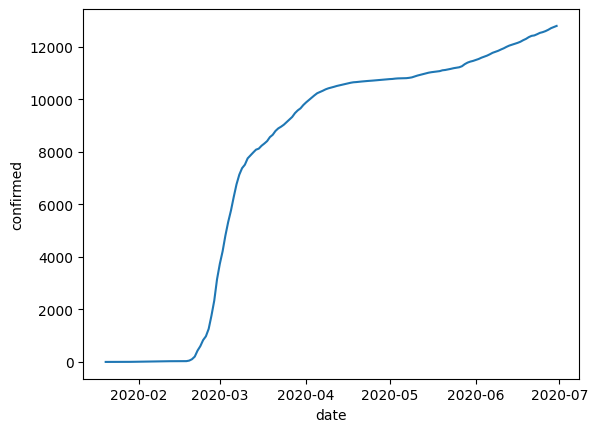

In [21]:
sns.lineplot(x=time_df.index, y="confirmed", data=time_df)

### TimeAge.csv

**Time series data of COVID-19 status in terms of the age in South Korea**

* `date`: YYYY-MM-DD
    * The status in terms of the age has been presented since March 2nd.

* `time`: Time

* `age`: the age of patients

* `confirmed`: the accumulated number of the confirmed

* `deceased`: the accumulated number of the deceased

In [22]:
time_age_df.head(15)

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1
5,2020-03-02,0,50s,834,5
6,2020-03-02,0,60s,530,6
7,2020-03-02,0,70s,192,6
8,2020-03-02,0,80s,81,3
9,2020-03-03,0,0s,34,0


In [23]:
time_age_df.shape

(1089, 5)

In [24]:
time_df.dtypes

time         int64
test         int64
negative     int64
confirmed    int64
released     int64
deceased     int64
dtype: object

In [25]:
time_df.isna().sum()

time         0
test         0
negative     0
confirmed    0
released     0
deceased     0
dtype: int64

### TimeGender.csv

**Time series data of COVID-19 status in terms of the gender in South Korea**

* `date`: YYYY-MM-DD
    * The status in terms of the gender has been presented since March 2nd.

* `time`: Time

* `sex`: the gender of patients

* `confirmed`: the accumulated number of the confirmed

* `deceased`: the accumulated number of the deceased

In [26]:
time_gender_df.head()

,date,time,sex,confirmed,deceased
0,2020-03-02,0,male,1591,13
1,2020-03-02,0,female,2621,9
2,2020-03-03,0,male,1810,16
3,2020-03-03,0,female,3002,12
4,2020-03-04,0,male,1996,20


In [27]:
time_gender_df.shape

(242, 5)

In [28]:
time_gender_df.dtypes

date         object
time          int64
sex          object
confirmed     int64
deceased      int64
dtype: object

In [29]:
time_gender_df["date"] = pd.to_datetime(time_gender_df["date"])

In [30]:
time_gender_df.dtypes

date         datetime64[ns]
time                  int64
sex                  object
confirmed             int64
deceased              int64
dtype: object

In [31]:
time_gender_df.isna().sum()

date         0
time         0
sex          0
confirmed    0
deceased     0
dtype: int64

In [32]:
time_gender_df = time_gender_df.set_index(["sex", "date"])

In [33]:
time_gender_df.head()

,,time,confirmed,deceased
sex,date,,,
male,2020-03-02,0,1591,13
female,2020-03-02,0,2621,9
male,2020-03-03,0,1810,16
female,2020-03-03,0,3002,12
male,2020-03-04,0,1996,20


<Axes: xlabel='date', ylabel='confirmed'>

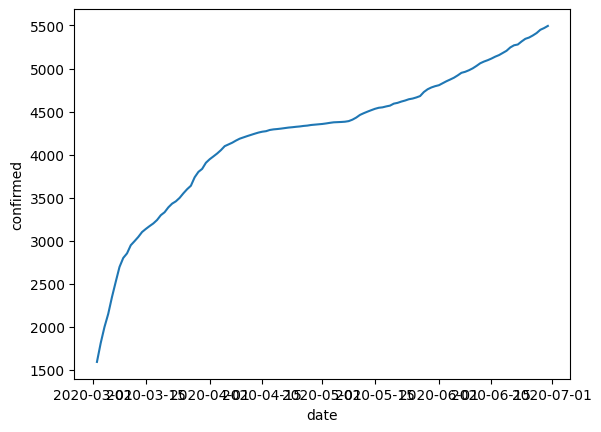

In [34]:
sns.lineplot(x=time_gender_df.loc["male"].index, y="confirmed", data=time_gender_df.loc["male"])

<Axes: xlabel='date', ylabel='confirmed'>

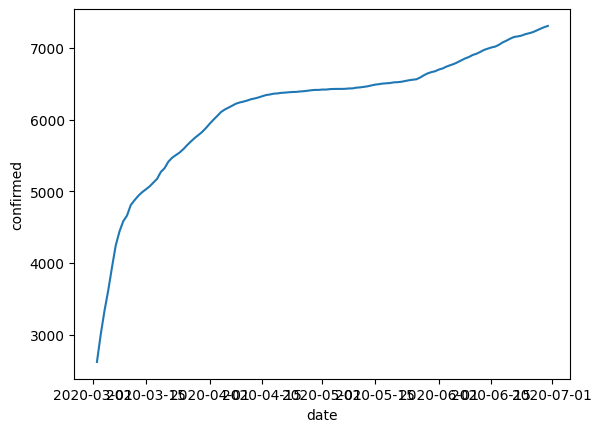

In [35]:
sns.lineplot(x=time_gender_df.loc["female"].index, y="confirmed", data=time_gender_df.loc["female"])

### TimeProvince.csv

**Time series data of COVID-19 status in terms of the Province in South Korea**

* `date`: YYYY-MM-DD

* `time`: Time

* `province`: the province of South Korea

* `confirmed`: the accumulated number of the confirmed in the province
    * The confirmed status in terms of the provinces has been presented since Feburary 21th.
    * The value before Feburary 21th can be different.

* `released`: the accumulated number of the released in the province
    * The confirmed status in terms of the provinces has been presented since March 5th.
    * The value before March 5th can be different.

* `deceased`: the accumulated number of the deceased in the province
    * The confirmed status in terms of the provinces has been presented since March 5th.
    * The value before March 5th can be different.

In [36]:
time_province_df.head(10)

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0
5,2020-01-20,16,Daejeon,0,0,0
6,2020-01-20,16,Ulsan,0,0,0
7,2020-01-20,16,Sejong,0,0,0
8,2020-01-20,16,Gyeonggi-do,0,0,0
9,2020-01-20,16,Gangwon-do,0,0,0


In [37]:
time_province_df.shape

(2771, 6)

In [38]:
time_province_df.dtypes

date         object
time          int64
province     object
confirmed     int64
released      int64
deceased      int64
dtype: object

In [39]:
time_province_df.isna().sum()

date         0
time         0
province     0
confirmed    0
released     0
deceased     0
dtype: int64

### Region.csv

**Location and statistical data of the regions in South Korea**

* `code`: the code of the region

* `province`: Special City / Metropolitan City / Province(-do)

* `city`: City(-si) / Country (-gun) / District (-gu)

* `latitude`: the latitude of the visit (WGS84)

* `longitude`: the longitude of the visit (WGS84)

* `elementary_school_count`: the number of elementary schools

* `kindergarten_count`: the number of kindergartens

* `university_count`: the number of universities

* `academy_ratio`: the ratio of academies

* `elderly_population_ratio`: the ratio of the elderly population

* `elderly_alone_ratio`: the ratio of elderly households living alone

* `nursing_home_count`: the number of nursing homes

In [40]:
region_df.head()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080


In [41]:
region_df.shape

(244, 12)

In [42]:
region_df.dtypes

code                          int64
province                     object
city                         object
latitude                    float64
longitude                   float64
elementary_school_count       int64
kindergarten_count            int64
university_count              int64
academy_ratio               float64
elderly_population_ratio    float64
elderly_alone_ratio         float64
nursing_home_count            int64
dtype: object

In [43]:
region_df.isna().sum()

code                        0
province                    0
city                        0
latitude                    0
longitude                   0
elementary_school_count     0
kindergarten_count          0
university_count            0
academy_ratio               0
elderly_population_ratio    0
elderly_alone_ratio         0
nursing_home_count          0
dtype: int64

### Weather.csv

**Data of the weather in the regions of South Korea**

* `code` the code of the region

* `province`: Special City / Metropolitan City / Province(-do)

* `date`: YYYY-MM-DD

* `avg_temp`: the average temperature

* `min_temp`: the lowest temperature

* `max_temp`: the highest temperature

* `precipitation`: the daily precipitation

* `max_wind_speed`: the maximum wind speed

* `most_wind_direction`: the most frequent wind direction

* `avg_relative_humidity`: the average relative humidity

In [44]:
weather_df.head()

,code,province,date,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
0,10000,Seoul,2016-01-01,1.2,-3.3,4.0,0.0,3.5,90.0,73.0
1,11000,Busan,2016-01-01,5.3,1.1,10.9,0.0,7.4,340.0,52.1
2,12000,Daegu,2016-01-01,1.7,-4.0,8.0,0.0,3.7,270.0,70.5
3,13000,Gwangju,2016-01-01,3.2,-1.5,8.1,0.0,2.7,230.0,73.1
4,14000,Incheon,2016-01-01,3.1,-0.4,5.7,0.0,5.3,180.0,83.9


In [45]:
weather_df.shape

(26271, 10)

In [46]:
weather_df.dtypes

code                       int64
province                  object
date                      object
avg_temp                 float64
min_temp                 float64
max_temp                 float64
precipitation            float64
max_wind_speed           float64
most_wind_direction      float64
avg_relative_humidity    float64
dtype: object

In [47]:
weather_df.isna().sum()

code                      0
province                  0
date                      0
avg_temp                 15
min_temp                  5
max_temp                  3
precipitation             0
max_wind_speed            9
most_wind_direction      29
avg_relative_humidity    20
dtype: int64

### SearchTrend.csv

**Trend data of the keywords searched in NAVER which is one of the largest portal in South Korea**

* `date`: YYYY-MM-DD

* `cold`: the search volume of 'cold' in Korean language
    * The unit means relative value by setting the highest search volume in the period to 100.

* `flu`: the search volume of 'flu' in Korean language
    * Same as above.

* `pneumonia`: the search volume of 'pneumonia' in Korean language
    * Same as above.

* `coronavirus`: the search volume of 'coronavirus' in Korean language
    * Same as above.

In [48]:
search_df.head()

,date,cold,flu,pneumonia,coronavirus
0,2016-01-01,0.11663,0.05590,0.15726,0.00736
1,2016-01-02,0.13372,0.17135,0.20826,0.00890
2,2016-01-03,0.14917,0.22317,0.19326,0.00845
3,2016-01-04,0.17463,0.18626,0.29008,0.01145
4,2016-01-05,0.17226,0.15072,0.24562,0.01381


In [49]:
search_df.shape

(1642, 5)

In [50]:
search_df.dtypes

date            object
cold           float64
flu            float64
pneumonia      float64
coronavirus    float64
dtype: object

In [51]:
search_df["date"] = pd.to_datetime(search_df["date"])

In [52]:
search_df.dtypes

date           datetime64[ns]
cold                  float64
flu                   float64
pneumonia             float64
coronavirus           float64
dtype: object

In [53]:
search_df.isna().sum()

date           0
cold           0
flu            0
pneumonia      0
coronavirus    0
dtype: int64

In [54]:
search_df = search_df.set_index("date")

<Axes: xlabel='date', ylabel='coronavirus'>

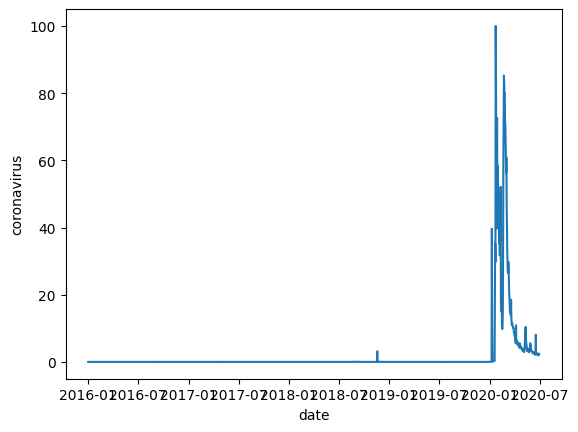

In [55]:
sns.lineplot(x=search_df.index, y="coronavirus", data=search_df)

<Axes: xlabel='date', ylabel='flu'>

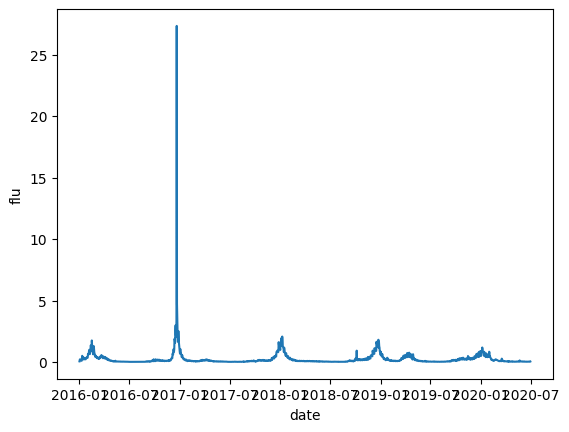

In [56]:
sns.lineplot(x=search_df.index, y="flu", data=search_df)

<Axes: xlabel='date', ylabel='cold'>

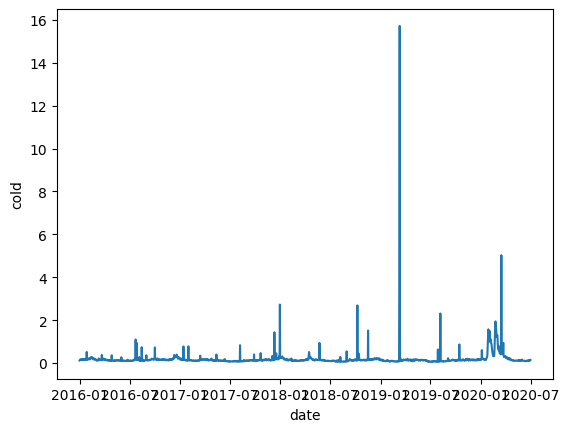

In [57]:
sns.lineplot(x=search_df.index, y="cold", data=search_df)

### SeoulFloating.csv

**Data of floating population in Seoul, South Korea (from SK Telecom Big Data Hub)**

* `date`: YYYY-MM-DD

* `hour`: Hour

* `birth_year`: the birth year of the floating population

* `sex`: the sex of the floating population

* `province`: Special City / Metropolitan City / Province(-do)

* `city`: City(-si) / Country (-gun) / District (-gu)

* `fp_num`: the number of floating population

In [58]:
floating_df.tail(5)

,date,hour,birth_year,sex,province,city,fp_num
1084795,2020-05-31,21,40,female,Seoul,Dobong-gu,27620
1084796,2020-05-31,21,40,female,Seoul,Songpa-gu,56560
1084797,2020-05-31,21,50,female,Seoul,Gangdong-gu,38960
1084798,2020-05-31,22,60,female,Seoul,Guro-gu,25420
1084799,2020-05-31,23,40,male,Seoul,Eunpyeong-gu,38650


### Policy.csv

**Data of the government policy for COVID-19 in South Korea**

* `policy_id`: the ID of the policy

* `country`: the country that implemented the policy

* `type`: the type of the policy

* `gov_policy`: the policy of the government

* `detail`: the detail of the policy

* `start_date`: the start date of the policy

* `end_date`: the end date of the policy

In [59]:
policy_df.head()

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN


In [60]:
policy_df.shape

(61, 7)

In [61]:
policy_df.dtypes

policy_id      int64
country       object
type          object
gov_policy    object
detail        object
start_date    object
end_date      object
dtype: object

In [62]:
policy_df["start_date"] = pd.to_datetime(policy_df["start_date"])
policy_df["end_date"] = pd.to_datetime(policy_df["end_date"])

In [63]:
policy_df.dtypes

policy_id              int64
country               object
type                  object
gov_policy            object
detail                object
start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

In [64]:
policy_df.isna().sum()

policy_id      0
country        0
type           0
gov_policy     0
detail         2
start_date     0
end_date      37
dtype: int64

In [65]:
policy_df["country"].unique()

array(['Korea'], dtype=object)

In [66]:
policy_df["type"].unique()

array(['Alert', 'Immigration', 'Health', 'Social', 'Education',
       'Technology', 'Administrative', 'Transformation'], dtype=object)

In [67]:
policy_df["gov_policy"].unique()

array(['Infectious Disease Alert Level', 'Special Immigration Procedure',
       'Mandatory 14-day Self-Quarantine',
       'Mandatory Self-Quarantine & Diagonostic Tests',
       'Emergency Use Authorization of Diagnostic Kit',
       'Drive-Through Screening Center', 'Mask Distribution',
       'Social Distancing Campaign', 'Thanks to Challenge korea',
       'School Closure', 'School Opening Delay',
       'School Opening with Online Class', 'Open Data ', 'Open API',
       'Self-Diagnosis App', 'Self-Quarantine Safety Protection App',
       'Electronic Wristbands', 'Close bars and clubs',
       'local government Administrative orders', 'Close karaoke',
       'Logistics center', 'Wearing of masks',
       'KI-Pass: Korea Internet - Pass',
       'Extends Tightened Quarantine Measures '], dtype=object)

In [68]:
policy_df["detail"].unique()

array(['Level 1 (Blue)', 'Level 2 (Yellow)', 'Level 3 (Orange)',
       'Level 4 (Red)', 'from China', 'from Hong Kong', 'from Macau',
       'from Japan', 'from Italy', 'from Iran', 'from France',
       'from Germany', 'from Spain', 'from U.K.', 'from Netherlands',
       'from Europe', 'from all the countries', 'from U.S.', '1st EUA',
       '2nd EUA', '3rd EUA', '4th EUA', '5th EUA', 'by Local Government',
       'Standard Operating Procedures', 'Public-Sale',
       '5-day Rotation System', 'Strong', 'Weak', 'Weak(1st)',
       'Relay Cheer Campaign in SNS', 'Daycare Center for Children',
       'Kindergarten', 'High School', 'Middle School',
       'Elementary School', 'High School (3rd grade)',
       'High School (2nd grade)', 'High School (1st grade)',
       'Middle School (3rd grade)', 'Middle School (2nd grade)',
       'Middle School (1st grade)', 'Elementary School (5th ~ 6th grade)',
       'Elementary School (4th grade)', 'Elementary School (3rd grade)',
       'Element